In [1]:
import astropy.units as u
import numpy as np
import doodads as dd
dd.init()

# Bobcat evolution cool-down plots

In [2]:
tabulated_masses = np.unique(dd.BOBCAT_EVOLUTION_TABLES_M0.mass['mass_Msun']) * u.Msun
tabulated_ages = np.unique(dd.BOBCAT_EVOLUTION_TABLES_M0.mass['age_Gyr']) * u.Gyr

[Text(0.5, 0, 'age [Gyr]'), Text(0, 0.5, 'T_eff [K]')]

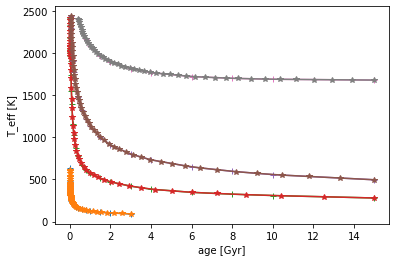

In [3]:
for test_mass in tabulated_masses[::20]:
    mask = dd.BOBCAT_EVOLUTION_TABLES_M0.mass['mass_Msun'] == test_mass.to(u.Msun).value
    subset = dd.BOBCAT_EVOLUTION_TABLES_M0.mass[mask]
    plt.plot(subset['age_Gyr'], subset['T_eff_K'], '+-')

    interp_ages = np.logspace(np.log10(np.min(subset['age_Gyr'])), np.log10(np.max(subset['age_Gyr']))) * u.Gyr
    if interp_ages[-1] > np.max(subset['age_Gyr']) * u.Gyr:
        interp_ages[-1] = np.max(subset['age_Gyr']) * u.Gyr
    T_evol, T_eff, surface_gravity, mag = dd.BOBCAT_EVOLUTION_M0.mass_age_to_properties(
        test_mass,
        interp_ages,
        dd.CLIO_3_9_FILTER,
    )
    plt.plot(interp_ages, T_eff, '*-')
# plt.xscale('log')
# plt.yscale('log')
plt.gca().set(
    xlabel='age [Gyr]',
    ylabel='T_eff [K]',
)

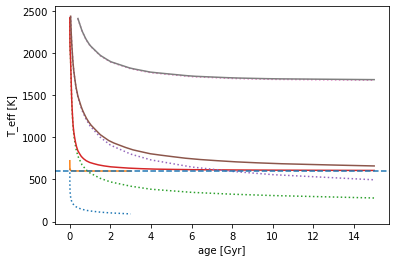

In [4]:
T_eq = 600*u.K

for test_mass in tabulated_masses[::20]:
    mask = dd.BOBCAT_EVOLUTION_TABLES_M0.mass['mass_Msun'] == test_mass.to(u.Msun).value
    subset = dd.BOBCAT_EVOLUTION_TABLES_M0.mass[mask]
    plt.plot(subset['age_Gyr'], subset['T_eff_K'], ls=':')
    interp_ages = np.logspace(np.log10(np.min(subset['age_Gyr'])), np.log10(np.max(subset['age_Gyr']))) * u.Gyr
    if interp_ages[-1] > np.max(subset['age_Gyr']) * u.Gyr:
        interp_ages[-1] = np.max(subset['age_Gyr']) * u.Gyr
    T_evol, T_eff, surface_gravity, mag = dd.BOBCAT_EVOLUTION_M0.mass_age_to_properties(
        test_mass,
        interp_ages,
        dd.CLIO_3_9_FILTER,
        T_eq=T_eq
    )
    plt.plot(interp_ages, T_eff)

plt.gca().set(
    xlabel='age [Gyr]',
    ylabel='T_eff [K]',
)
plt.axhline(T_eq, ls='--')

# Bobcat synthetic photometry comparison plots

In [5]:
phot_tbl = dd.ref.bobcat.load_bobcat_photometry('photometry_tables/mag_table+0.0')

In [6]:
phot_masses = np.unique(phot_tbl['mass_Mjup']) * u.Mjup

OOB: T_eff=<Quantity 2401. K> g=<Quantity 3198.89595263 cm / s2> mass=<Quantity 9.88 jupiterMass>


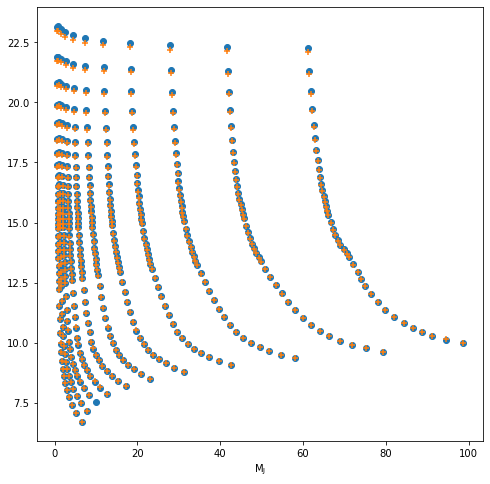

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(phot_tbl['mass_Mjup'] * u.Mjup, phot_tbl['mag_MKO_Lprime'], label='Bobcat reference')

masses, mags = np.zeros(len(phot_tbl)) * u.Mjup, np.zeros(len(phot_tbl))
for idx, row in enumerate(phot_tbl):
    T_eff = row['T_eff_K'] * u.K
    g = 10**row['log_g_cm_per_s2'] * u.cm/u.s**2
    # conversion imprecision means we are overshooting the upper limit when
    # really we should just clip it to 3160 m/s^2
    if np.abs((g - 3160 * u.m/u.s**2) / (3160 * u.m/u.s**2)) < 0.01:
        g = 3160 * u.m/u.s**2
    mass = row['mass_Mjup'] * u.Mjup
    try:
        spec = dd.BOBCAT_SPECTRA_M0.get(
            temperature=T_eff,
            surface_gravity=g,
            mass=mass,
        )
    except dd.ref.model_grids.BoundsError:
        print(f"OOB: {T_eff=} {g=} {mass=}")
        masses[idx] = np.nan
        mags[idx] = np.nan
        continue
    masses[idx] = mass
    mag = dd.VEGA_BOHLIN_GILLILAND_2004.magnitude(spec, dd.MKO.Lprime)
    mags[idx] = mag
    
plt.scatter(masses, mags, marker='+')

Some kind of systematic error exists at low magnitudes, but the fractional error in magnitude is small. Small changes in filter width can produce this sort of error, as can different/any atmosphere models, different Vega models, etc.

To verify:

Text(0, 0.5, 'Number of table rows')

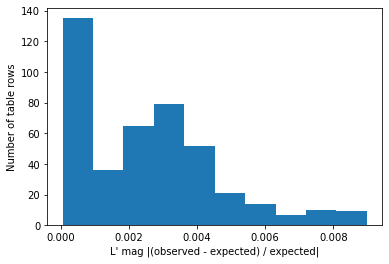

In [8]:
_ = plt.hist(np.abs((mags - phot_tbl['mag_MKO_Lprime'])/phot_tbl['mag_MKO_Lprime']))
plt.xlabel('L\' mag |(observed - expected) / expected|')
plt.ylabel('Number of table rows')

The maximum relative error in magnitude is < 1%:

In [9]:
np.nanmax(np.abs((mags - phot_tbl['mag_MKO_Lprime'])/phot_tbl['mag_MKO_Lprime']))

0.008985546387133265